## TODO on Hierarchical Inference

3) Decide on a specific method for dealing with outlier samples in the interim prior. It's currently hard coded to set them to the boundary, but this will bias inference

In [1]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
%matplotlib inline
from ovejero import model_trainer, hierarchical_inference
from multiprocessing import Pool

In [4]:
hierarchical_inference.lens_samps

array([[[ 3.79306525e-02,  4.91132889e-02,  6.29500616e-02, ...,
          3.61691938e-02,  5.20873078e-02,  3.49692367e-02],
        [ 4.51689164e-02,  3.71465778e-02,  9.78766128e-02, ...,
          4.12151619e-02,  5.63837587e-02,  4.25089030e-02],
        [ 4.54002410e-02,  3.92184202e-02,  7.34550685e-02, ...,
          4.49125015e-02,  6.98886515e-02,  5.05593923e-02],
        ...,
        [ 4.36833399e-02,  3.02334826e-02,  6.64396337e-02, ...,
          3.37790454e-02,  4.84192810e-02,  2.52885173e-02],
        [ 3.96336520e-02,  3.93914917e-02,  7.12001252e-02, ...,
          5.05735656e-02,  6.93741955e-02,  3.06367183e-02],
        [ 4.23381643e-02,  4.36862810e-02,  8.57245343e-02, ...,
          3.40797873e-02,  4.68588667e-02,  3.63236039e-02]],

       [[-4.51414866e-01,  6.47994440e-01, -7.76196139e-01, ...,
          1.16855927e+00, -2.33963169e-01,  1.20640949e+00],
        [-6.45286928e-01,  5.69772709e-01, -7.47127643e-01, ...,
          1.10241886e+00, -2.03061716e

## NN1

In [3]:
# First specify the config path
root_path = '/Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/'
config_path = root_path + 'configs/nn1.json'

# We also need the path to the baobab configs for the interim and target omega
interim_baobab_omega_path = root_path + 'configs/baobab_configs/train_diagonal.py'
target_baobab_omega_path = root_path + 'configs/baobab_configs/test_baobab_cfg_prior.py'

test_dataset_path = '/Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/datasets/cent_narrow/'
test_dataset_rf_record_path = test_dataset_path + 'tf_dataset'

# Check that the config has what you need
cfg = model_trainer.load_config(config_path)

# Correct any path issues.
def recursive_str_checker(cfg_dict):
    for key in cfg_dict:
        if isinstance(cfg_dict[key],str):
            cfg_dict[key] = cfg_dict[key].replace('/home/swagnercarena/ovejero/',root_path)
        if isinstance(cfg_dict[key],dict):
            recursive_str_checker(cfg_dict[key])
recursive_str_checker(cfg)

# The InferenceClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the validation dataset, and providing outputs correctly marginalized over the BNN uncertainties.
hier_infer = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_baobab_omega_path,
                                                      test_dataset_path,test_dataset_rf_record_path)

# Now we just have to ask the InferenceClass to spin up some samples from our BNN. The more samples, the more
# accurate our plots and metrics will be. The right value to use unfortunately requires a bit of trial and error.
# 100 is a good starting point though.
num_samples = 1000
save_path_samples = '/Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/hierarchical_results/nn1_samples.npy'
hier_infer.gen_samples(num_samples,save_path_samples)

Is model built: True
Loaded weights /Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/models/nn1.h5
TFRecord found at /Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/datasets/cent_narrow/tf_dataset
Loading samples from /Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/hierarchical_results/nn1_samples.npy


In [5]:
n_walkers = 50
save_path_chains = '/Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/hierarchical_results/nn1_chains_fudge.h5'
pool = Pool()
hier_infer.initialize_sampler(n_walkers,save_path_chains,pool=pool)


Loaded chains found at /Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/hierarchical_results/nn1_chains_fudge.h5


In [8]:
# %%prun -s cumulative
n_samps = 20
hier_infer.run_sampler(n_samps)

In [7]:
hyperparam_plot_names = [r'$\mu_{\gamma_\mathrm{ext}}$',r'$\sigma_{\gamma_\mathrm{ext}}$',
                         r'$\mu_\psi$',r'$\alpha_\psi$',r'$p_\psi$',r'$\mathrm{lower}_\psi$',
                         r'$\mathrm{upper}_\psi$',r'$\mu_x$',r'$\sigma_x$',r'$\mu_y$',r'$\sigma_y$',
                         r'$a_{e1}$',r'$b_{e1}$',r'$\mathrm{lower}_{e1}$',r'$\mathrm{upper}_{e1}$',
                         r'$a_{e2}$',r'$b_{e2}$',r'$\mathrm{lower}_{e2}$',r'$\mathrm{upper}_{e2}$',
                         r'$\mu_{\gamma_\mathrm{lens}}$',r'$\sigma_{\gamma_\mathrm{lens}}$',
                         r'$\mu_{\theta_E}$',r'$\sigma_{\theta_E}$']

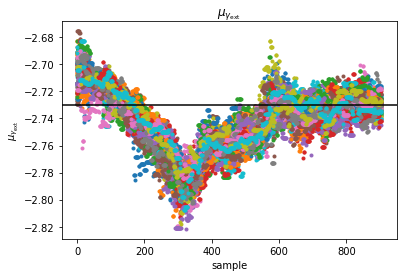

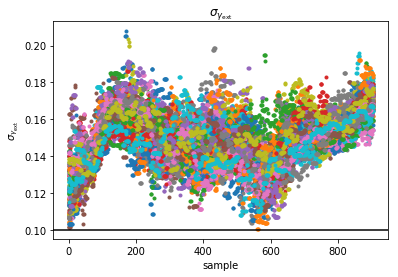

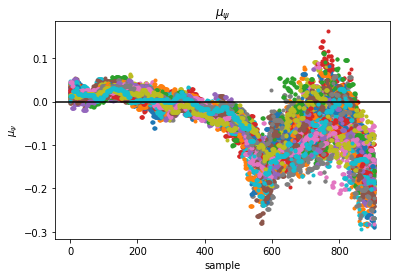

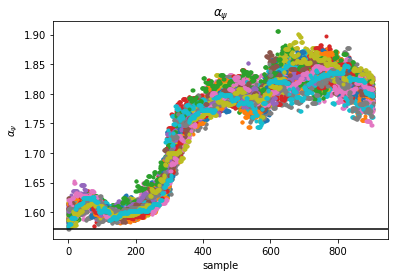

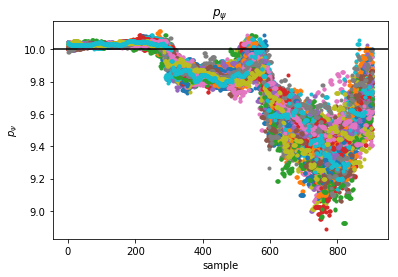

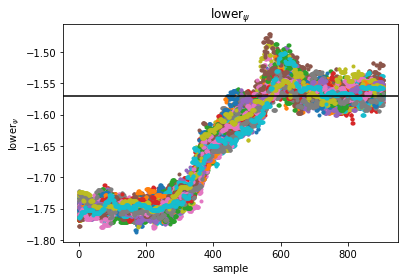

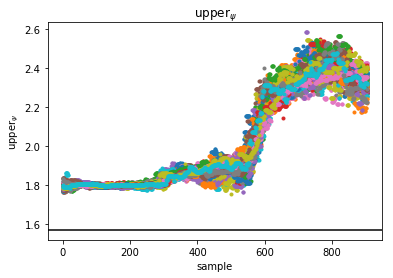

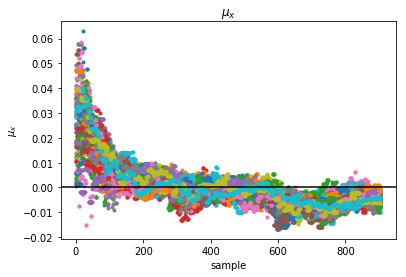

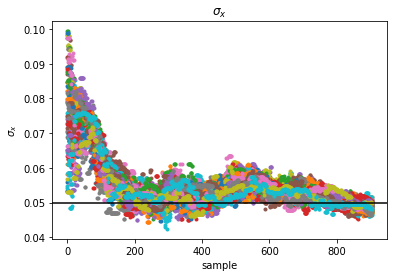

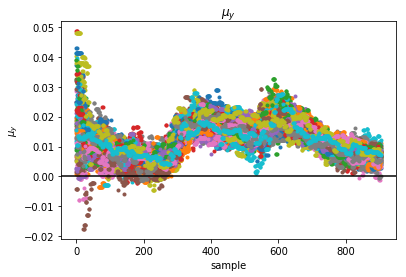

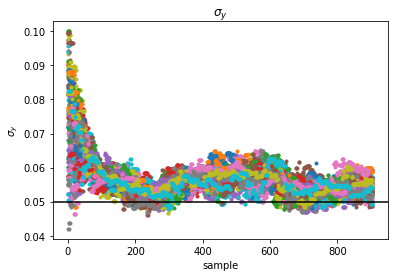

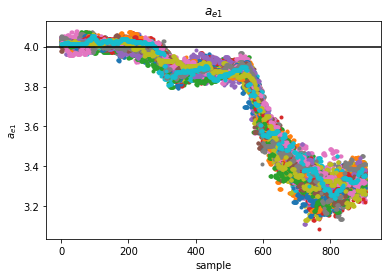

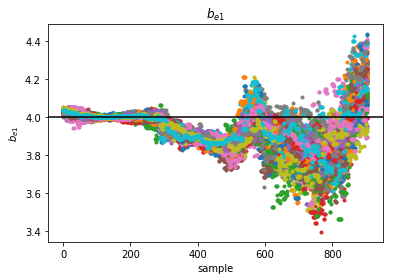

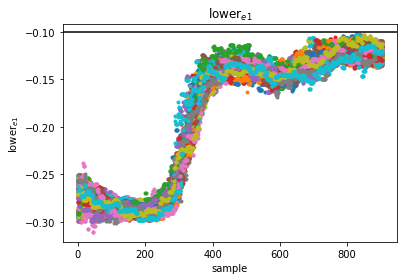

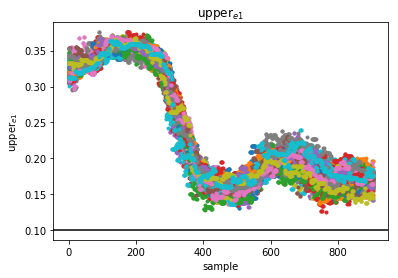

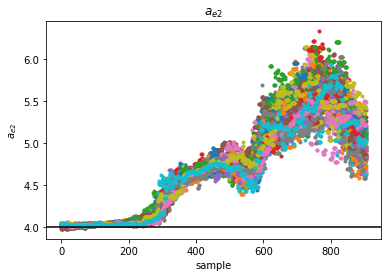

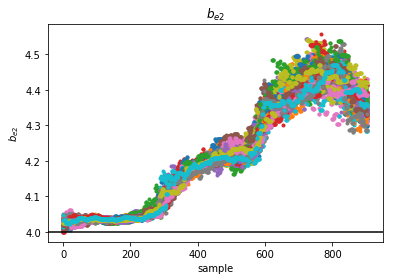

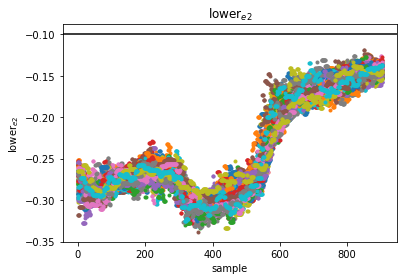

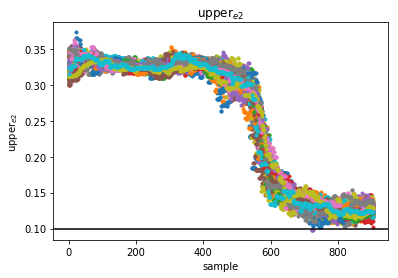

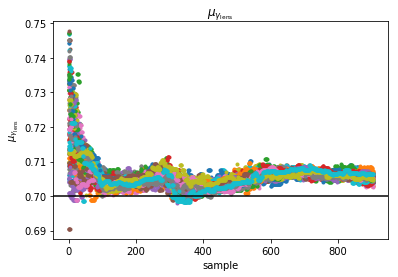

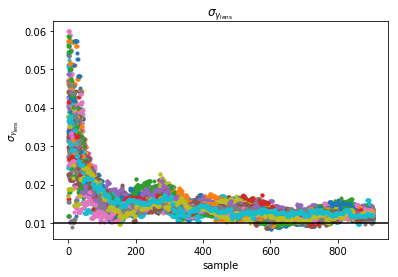

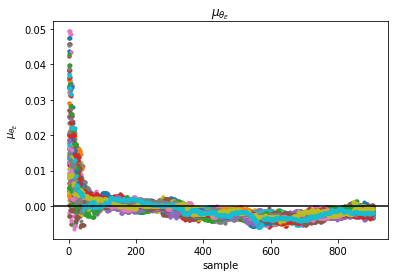

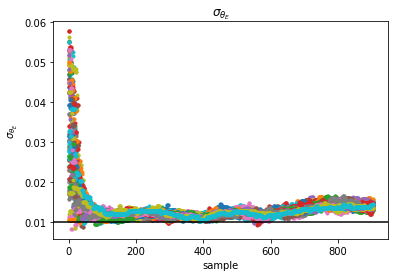

In [8]:
hier_infer.plot_chains(burnin=None,hyperparam_plot_names=hyperparam_plot_names)

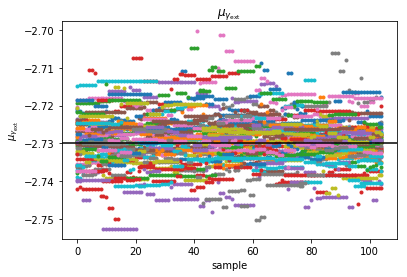

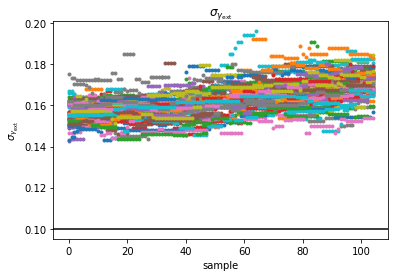

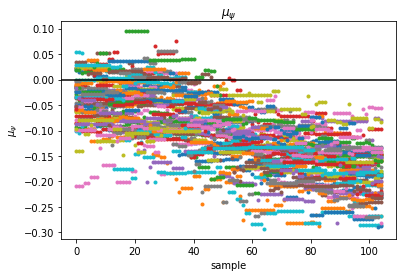

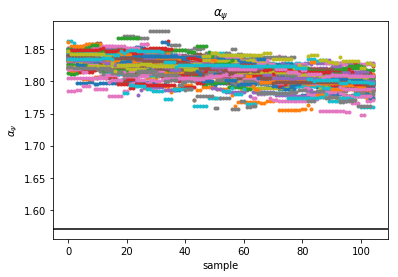

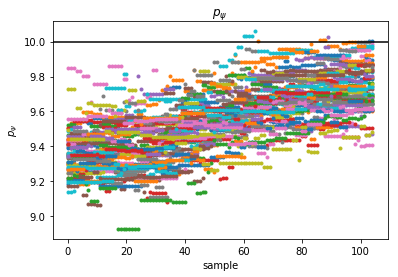

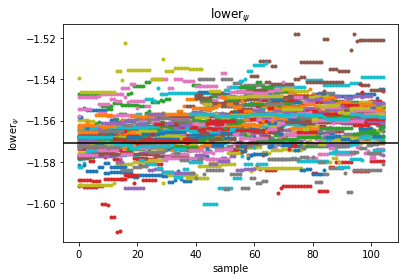

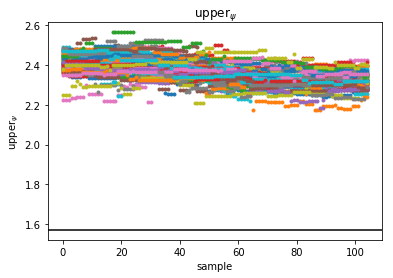

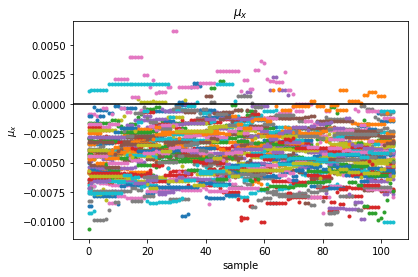

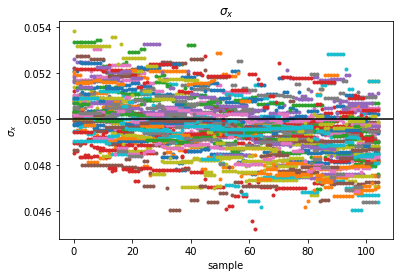

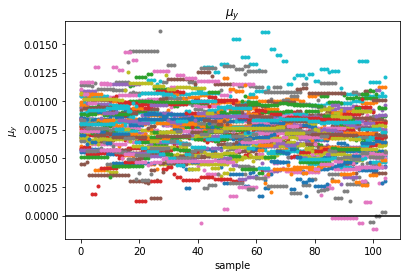

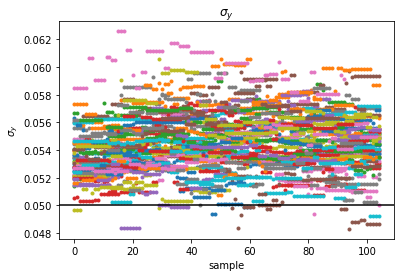

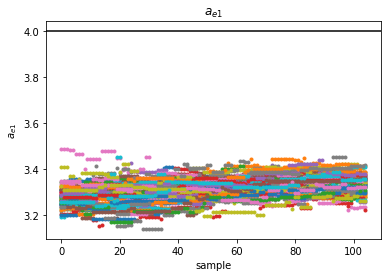

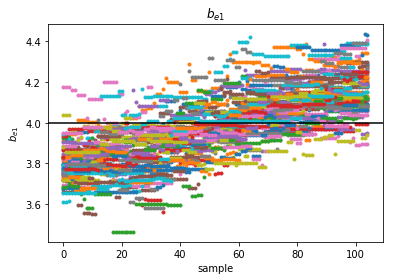

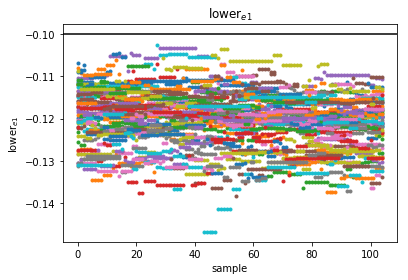

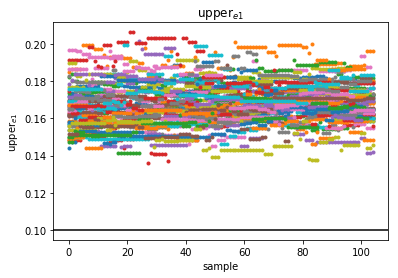

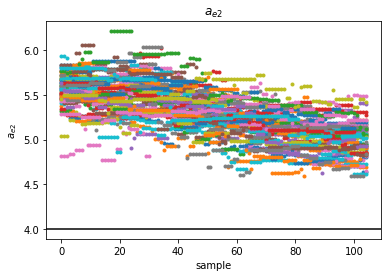

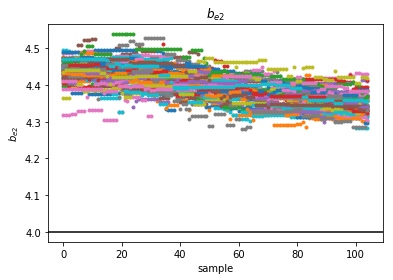

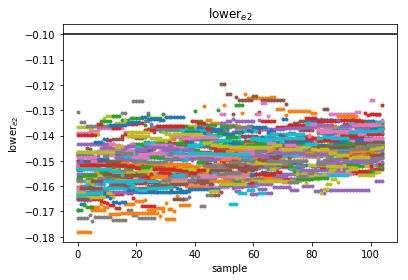

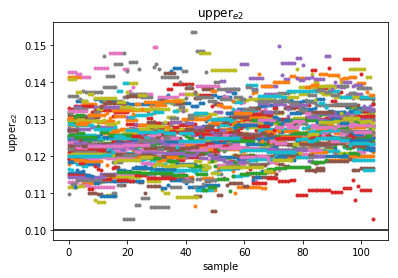

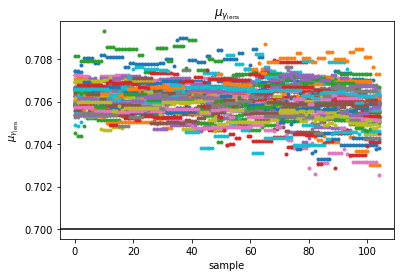

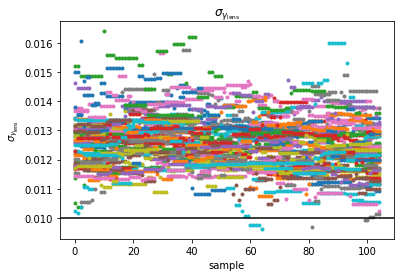

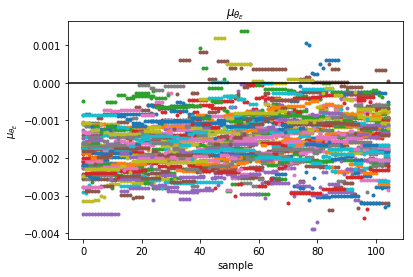

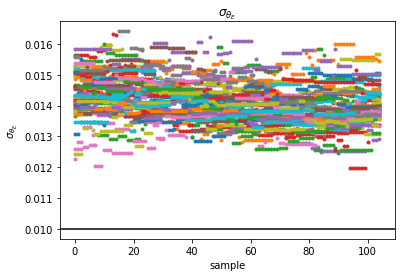

In [9]:
burnin = 800
hier_infer.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)

In [ ]:
hier_infer.plot_corner(burnin,hyperparam_plot_names)

In [ ]:
hier_infer.plot_distributions(burnin,hyperparam_plot_names)

## NN2

In [ ]:
# First specify the config path
config_path = root_path + 'configs/nn2.json'

# Check that the config has what you need
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)

# The InferenceClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the validation dataset, and providing outputs correctly marginalized over the BNN uncertainties.
hier_infer = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_baobab_omega_path,
                                                      test_dataset_path,test_dataset_rf_record_path)
num_samples = 1000
save_path_samples = '/Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/hierarchical_results/nn2_samples.npy'
hier_infer.gen_samples(num_samples,save_path_samples)

In [ ]:
n_walkers = 50
save_path_chains = '/Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/hierarchical_results/nn2_chains.h5'
hier_infer.initialize_sampler(n_walkers,save_path_chains)

In [ ]:
hier_infer.plot_chains(burnin=None,hyperparam_plot_names=hyperparam_plot_names)

In [ ]:
burnin = 800
hier_infer.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)

In [ ]:
hier_infer.plot_corner(burnin,hyperparam_plot_names)

In [ ]:
hier_infer.plot_distributions(burnin,hyperparam_plot_names)

## NN3

In [ ]:
# First specify the config path
config_path = root_path + 'configs/nn3.json'

# Check that the config has what you need
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)

# The InferenceClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the validation dataset, and providing outputs correctly marginalized over the BNN uncertainties.
hier_infer = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_baobab_omega_path,
                                                      test_dataset_path,test_dataset_rf_record_path)
num_samples = 1000
save_path_samples = '/Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/hierarchical_results/nn3_samples.npy'
hier_infer.gen_samples(num_samples,save_path_samples)

In [ ]:
n_walkers = 50
save_path_chains = '/Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/hierarchical_results/nn3_chains.h5'
hier_infer.initialize_sampler(n_walkers,save_path_chains)

In [ ]:
hier_infer.plot_chains(burnin=None,hyperparam_plot_names=hyperparam_plot_names)

In [ ]:
burnin = 800
hier_infer.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)

In [ ]:
hier_infer.plot_corner(burnin,hyperparam_plot_names)

In [ ]:
hier_infer.plot_distributions(burnin,hyperparam_plot_names)

In [ ]:
import numba
import numpy as np
from math import gamma
@numba.njit
def _beta_log_pdf_numba(eval_at,a,b):
    return np.log(eval_at)*(a-1)+np.log(1-eval_at)*(b-1)

@numba.njit
def eval_beta_logpdf_approx(eval_at,a,b,lower,upper):
    """Evaluate the beta pdf, scaled/shifted without -np.inf

    See `sample_beta` for parameter definitions.

    """

    # Terms we only want to calculate once
    norm = np.log(gamma(a+b)/(gamma(a)*gamma(b)))
    scale = upper - lower
    lscale = np.log(scale)

    # Epsilon parameter for approximation
    epsilon = 1e-9/scale

    # The evaluations
    eval_logpdf = _beta_log_pdf_numba((eval_at-lower)/scale,a,b)-lscale+norm
    stitch_upper = _beta_log_pdf_numba(1-epsilon,a,b)-lscale+norm
    stitch_lower = _beta_log_pdf_numba(epsilon,a,b)-lscale+norm

    # For loops are not a problem with numba
    for e_i in range(eval_at.shape[0]):
        for e_j in range(eval_at.shape[1]):
            if eval_at[e_i,e_j] < lower+epsilon:
                eval_logpdf[e_i,e_j] = stitch_lower - np.abs(eval_at[e_i,e_j] 
                    - lower -  epsilon)
            if eval_at[e_i,e_j] > upper-epsilon:
                eval_logpdf[e_i,e_j] = stitch_upper - np.abs(eval_at[e_i,e_j] 
                    - upper + epsilon)
    return eval_logpdf

In [ ]:
eval_beta_logpdf_approx(hier_infer.lens_samps[5],*[4,4,-1.5,1.5])